In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from collections import defaultdict
from IPython.display import clear_output

In [4]:
def loading_bar(place, size):
    count = int((float(place)/size) * 100)
    if place<=size:
        print(("=" * count) + ("_" * (100-count)), "{}/{}".format(place,size))
    else:
        print(("=" * count) + ("_" * (100-count)), "Done")

In [5]:
def test_digraph(G_func, param, start, interval, iterations=100):
    k_incr = defaultdict(list)

    for i in range(iterations):
        clear_output(wait=True)
        loading_bar(i, iterations)
        G = G_func(*param)
        for n in range(start+1):
            # get neighbors of in edges
            in_neighbors = [ f for f,t in G.in_edges(n) ]
            # find the current degree and how many new nodes attach to it
            old_n = [ v for v in in_neighbors if v <= start ]
            new_n = [ v for v in in_neighbors if v in range(start, start+interval)]
            k_incr[len(old_n)].append(len(new_n))
            
    clear_output(wait=True)
    loading_bar(iterations+1, iterations)
    return k_incr

In [6]:
def test_graph(G_func, param, start, interval, iterations=100):
    k_incr = defaultdict(list)

    for i in range(iterations):
        clear_output(wait=True)
        loading_bar(i, iterations)
        G = G_func(*param)
        for n in range(start+1):
            # get neighbors of in edges
            neighbors = [ f for f in G[n] ]
            # find the current degree and how many new nodes attach to it
            old_n = [ v for v in neighbors if v <= start ]
            new_n = [ v for v in neighbors if v in range(start, start+interval)]
            k_incr[len(old_n)].append(len(new_n))
           
    clear_output(wait=True)
    loading_bar(iterations+1, iterations)
    return k_incr

In [7]:
def model_stats(k_incr):
    k_avg = [ (k,sum(v)/float(len(v))) for k,v in k_incr.items() ]
    k_avg.sort()
    
    x = np.array([ k for k,v in k_avg ])
    y = [ v for k,v in k_avg ]
    y_pr = [ val/sum(y) for val in y ]
    
    fig, axs = plt.subplots(1,1, figsize=(5,5))
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y_pr)
    axs.plot(x, intercept + slope*x)
    axs.scatter( x, y_pr )
    axs.set_title('Degree vs. Attachment Rate', fontsize=20)
    axs.set_xlabel('Degree (k)', fontsize=15)
    axs.set_ylabel(r'Attachment Rate ( P(k $\rightarrow$ k+1) )', fontsize=15)
    
    return slope, intercept, r_value, p_value, std_err

In [8]:
def plotDegsDist(Deg, alpha=None, max_x=200):
    #Deg = [ d for _,d in degrees]
    counts = [ (i, float(Deg.count(i))/len(Deg)) for i in range(1, max(Deg)) if Deg.count(i) ]
    x,y = zip(*counts)

    def func_powerlaw(x, m):
        return x**m

    target_func = func_powerlaw


    p0 = [-2.5]
    popt, pcov = curve_fit(func_powerlaw, x, y, maxfev=2000)
    print(popt)

    plt.loglog(x, target_func(x, *popt), 'r--', label='Best Fit')
    if alpha != None:
        plt.loglog(range(1,max_x), [ val**alpha for val in range(1,max_x) ], 'm--', label='Custom Line')
    plt.loglog(x,y, 'co', label='Recorded')
    plt.xlabel('InDegree (k_in)', fontsize=15)
    plt.ylabel('Pr(k_in)', fontsize=15)
    plt.title('In Degree Distribution (loglog)', fontsize=20)
    plt.legend()
    plt.show()

In [9]:
def plotDegsCCDF(kis):
    # tabulate and display the CCDF Pr(K>=k)
    kmax    = max(kis)
    '''kis     = []
    for ki in degrees:
        kis.append(ki)
        if ki > kmax: kmax = ki'''

    counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.title('CCDF')
    plt.show()

In [10]:
def plotDegsStat(graph_func, param, iterations=1000, digraph=False, alpha=None, max_x=200):
    
    degrees = []
    
    for i in range(iterations):
        clear_output(wait=True)
        loading_bar(i, iterations)
        
        test_G = graph_func(*param)
        if digraph:
            degrees.extend( [ d for _,d in test_G.in_degree() ] )
        else:
            degrees.extend( [ d for _,d in test_G.degree() ] )
    
    clear_output(wait=True)
    loading_bar(iterations+1, iterations)
    plotDegsDist(degrees, alpha=alpha, max_x=max_x)
    plotDegsCCDF(degrees)

# Price Model

In [9]:
def price_model(size, C=3, alpha=1.5):
    # create DiGraph and seed network to create price model from
    G = nx.DiGraph()
    G.add_edge(1,0)
    
    # likelyhood to chose uniform random or proportional to in-degree
    weight = float(C)/(C + alpha)
    
    # Attach nodes following price's model
    # https://en.wikipedia.org/wiki/Price%27s_model
    for i in range(len(G),size):
        r = np.random.random() 

        if r < weight:
            # select based on in-degree
            sel_edge_index = np.random.choice(len(G.edges)) 
            sel_edge = list(G.edges())[sel_edge_index]
            node_sel = sel_edge[1]
        else:
            # select based on uniform random
            node_sel = np.random.choice(G.nodes)

        G.add_edge(i, node_sel)
    
    return G

In [22]:
# Graph parameters
size = 1000
params = [size]

('====================================================================================================', 'Done')


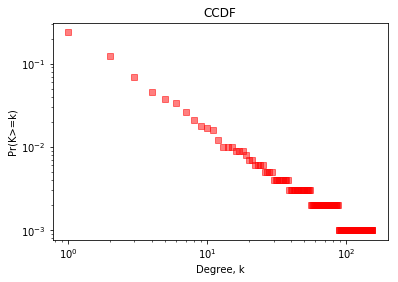

('Correlation: ', 0.9980323834518998)


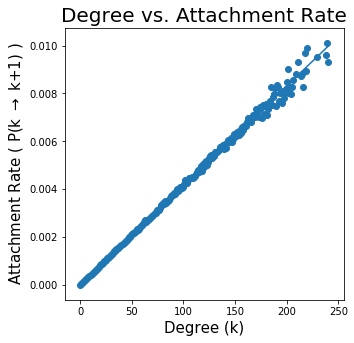

In [10]:
# Test parameters
interval = 500
start = 500
iterations = 10000

k_incr = test_digraph(price_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

('=====================================================================================================', 'Done')
[-2.92501617]


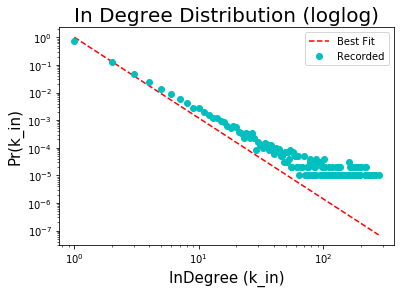

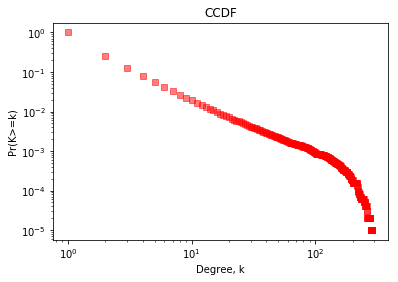

In [189]:
plotDegsStat(price_model, [1000], 100)

# Barabasi-Albert
 Networkx Built-In

In [21]:
# Graph parameters
size = 1000
m = 1
params = [size, m]

('====================================================================================================', 'Done')


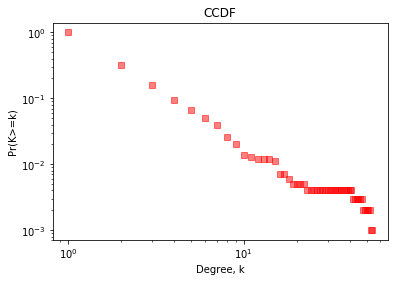

('Correlation: ', 0.9826457315993279)


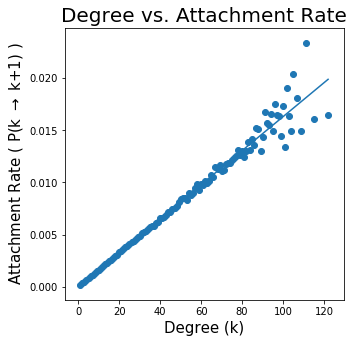

In [22]:
# Test parameters
interval = 500
start = 500
iterations = 10000

k_incr = test_graph(nx.barabasi_albert_graph, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

('=====================================================================================================', 'Done')
[-2.53588337]


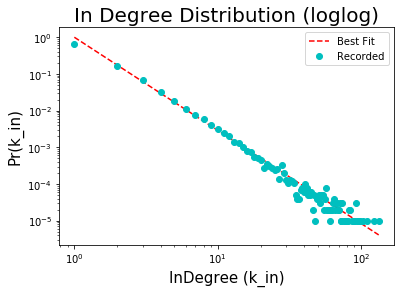

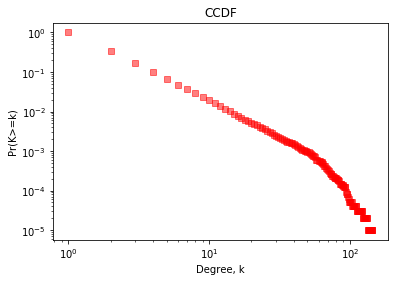

In [190]:
plotDegsStat(nx.barabasi_albert_graph, params, 100)

Personal Implementation

In [118]:
def barabasi_albert_model(size):
    G = nx.Graph()
    G.add_edge(0,1)

    for i in range(len(G),size):
        k_sum = 2*G.number_of_edges()
        
        prob = [ float(k)/k_sum for n,k in G.degree() ]  

        sel_node = np.random.choice(G.nodes(), p=prob)
        G.add_edge(i, sel_node)
        
    return G

In [23]:
# Graph parameters
size = 1000
params = [size]

('====================================================================================================', 'Done')


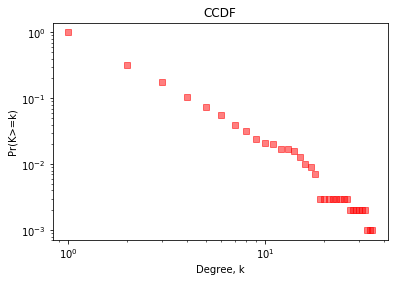

('Correlation: ', 0.9789499007943216)


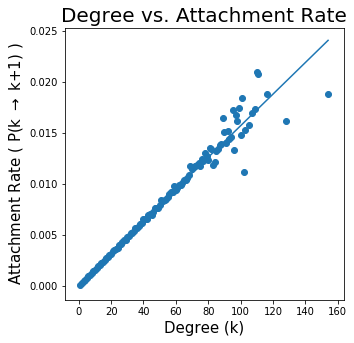

In [13]:
# Test parameters
interval = 500
start = 500
iterations = 10000

k_incr = test_graph(barabasi_albert_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

('=====================================================================================================', 'Done')
[-2.54107919]


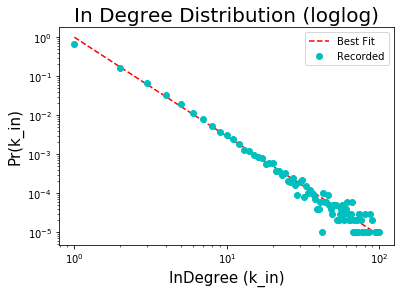

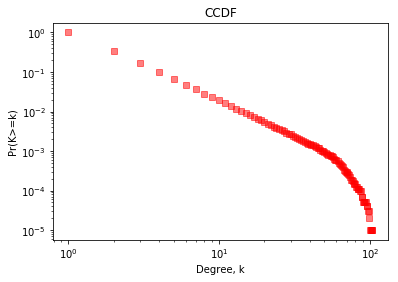

In [191]:
plotDegsStat(barabasi_albert_model, params, 100)

# Uniform Random

In [126]:
def uniform_random_model(size):
    G = nx.Graph()
    G.add_edge(0,1)
    
    for i in range(len(G),size):
        # len(G) == i
        sel_node = np.random.randint(0,i)
        G.add_edge(i, sel_node)
        
    return G

In [24]:
# Graph parameters
size = 1000
params = [size]

('====================================================================================================', 'Done')


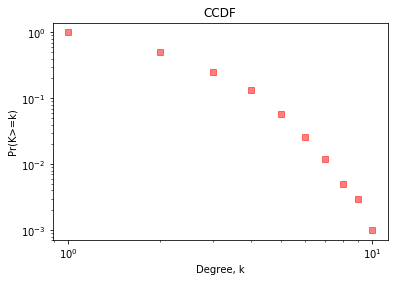

('Correlation: ', -0.5234142814819492)


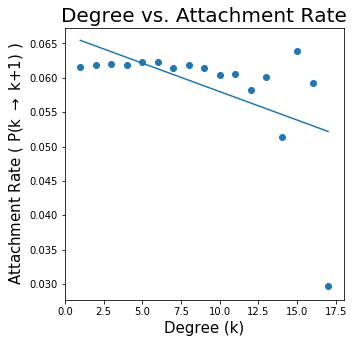

In [15]:
# Test parameters
interval = 500
start = 500
iterations = 10000

k_incr = test_graph(uniform_random_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

('=====================================================================================================', 'Done')
[-2.01865617]


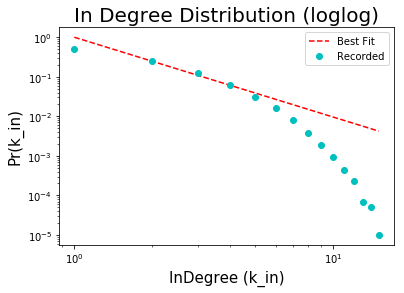

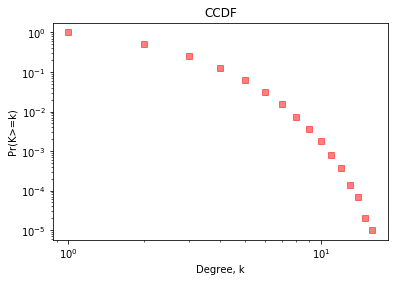

In [192]:
plotDegsStat(uniform_random_model, params, 100)

# Time Model

In [129]:
def time_model(size):
    G = nx.Graph()
    G.add_edge(0,1)
    
    for i in range(len(G), size):
        nodes = G.nodes()
        nodes_len = len(nodes)
        nodes_sum = sum(nodes)
        
        # randomly select node
        sel_node_prob = np.random.random()
        lower_bound = 0
        sel_node = -1
        
        for x in nodes:
            bucket_size = (nodes_len-x)/float(nodes_sum+i)
            upper_bound = lower_bound + bucket_size
            if sel_node_prob < upper_bound and sel_node_prob >= lower_bound:
                sel_node = x
            lower_bound = upper_bound
        
        G.add_edge(i, sel_node)
    
    return G

In [25]:
# Graph parameters
size = 1000
params = [size]

('====================================================================================================', 'Done')


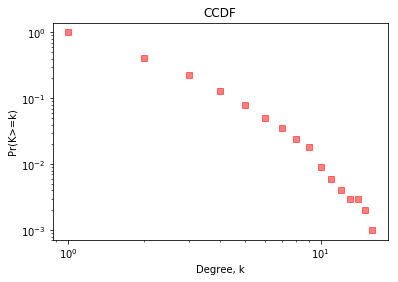

('Correlation: ', 0.3405310601745511)


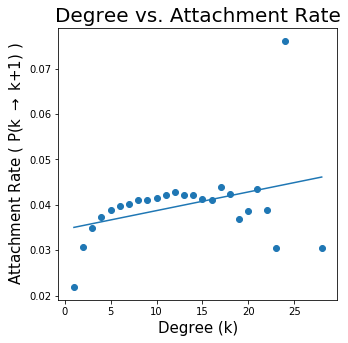

In [17]:
# Test parameters
interval = 500
start = 500
iterations = 10000

k_incr = test_graph(time_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

('=====================================================================================================', 'Done')


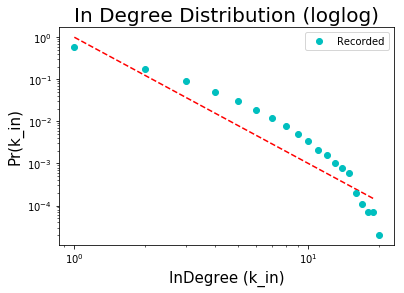

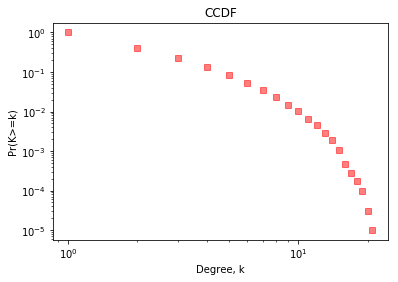

In [214]:
plotDegsStat(time_model, params, 100, alpha=-3, max_x=20)

# Geodesic Distance

In [131]:
def mean_geodesic_model(size):
    G = nx.Graph()
    G.add_edge(0,1)
    dist = np.zeros([size, size])
    avg = np.zeros(size)
    
    dist[1][0] = 1
    dist[0][1] = 1
    
    avg[0] = 1
    avg[1] = 1
    
    for i in range(len(G), size):
        mean_geo_dist = [ float(x)/(i-1) for x in avg[:i] ]
        mean_geo_sum = sum(mean_geo_dist)
        
        prob = [ float(x)/mean_geo_sum for x in mean_geo_dist ]
        sel_node = np.random.choice(G.nodes(), p=prob)
        G.add_edge(i, sel_node)
        dist[i,:i] = dist[sel_node,:i]+1
        dist[:i,i] = dist[:i,sel_node]+1
        
        avg[i] = avg[sel_node]+i
        for j in range(i):
            avg[j] = avg[j] + dist[j,sel_node] + 1
    
    #print(avg)
    #print(dist)
    return G

In [26]:
# Graph parameters
size = 1000
params = [size]

('====================================================================================================', 'Done')


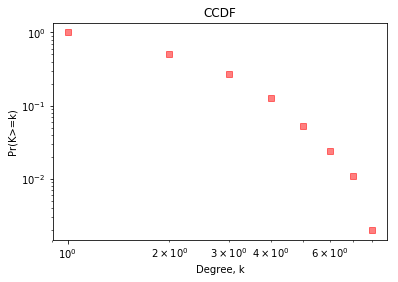

('Correlation: ', -0.6832144700465157)


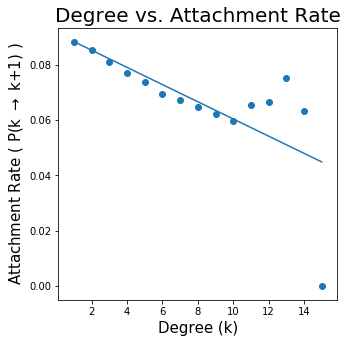

In [19]:
# Test parameters
interval = 500
start = 500
iterations = 10000

k_incr = test_graph(mean_geodesic_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

('==============================================================================================================', 'Done')
[-1.99879734]


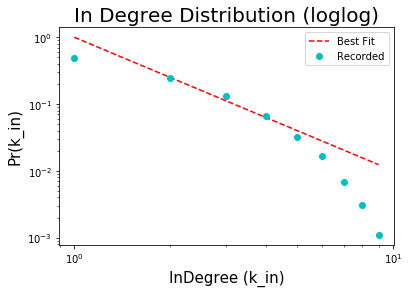

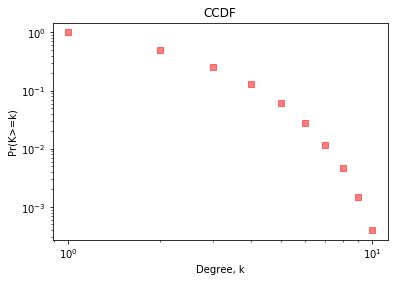

In [194]:
plotDegsStat(mean_geodesic_model, params, 10)

In [11]:
def inverse_mean_geodesic_model(size):
    G = nx.Graph()
    G.add_edge(0,1)
    dist = np.zeros([size, size])
    avg = np.zeros(size)
    
    dist[1][0] = 1
    dist[0][1] = 1
    
    avg[0] = 1
    avg[1] = 1
    
    for i in range(len(G), size):
        mean_geo_dist = [ float(x)/(i-1) for x in avg[:i] ]
        mean_geo_sum = sum(mean_geo_dist)
        
        inverse_prob = [ mean_geo_sum/float(x) for x in mean_geo_dist ]
        prob_sum = sum(inverse_prob)
        # Normalize
        prob = [ float(x)/prob_sum for x in inverse_prob]
        
        sel_node = np.random.choice(G.nodes(), p=prob)
        G.add_edge(i, sel_node)
        dist[i,:i] = dist[sel_node,:i]+1
        dist[:i,i] = dist[:i,sel_node]+1
        
        avg[i] = avg[sel_node]+i
        for j in range(i):
            avg[j] = avg[j] + dist[j,sel_node] + 1
    
    #print(avg)
    #print(dist)
    return G

In [27]:
# Graph parameters
size = 1000
params = [size]

('====================================================================================================', 'Done')


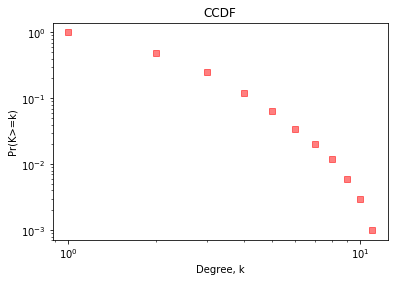

('Correlation: ', 0.2785602654309893)


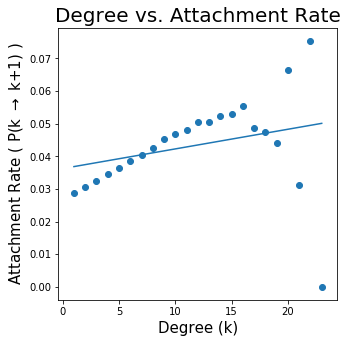

In [21]:
# Test parameters
interval = 500
start = 500
iterations = 10000

k_incr = test_graph(inverse_mean_geodesic_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

============================================================================================================== Done
[-2.05067441]


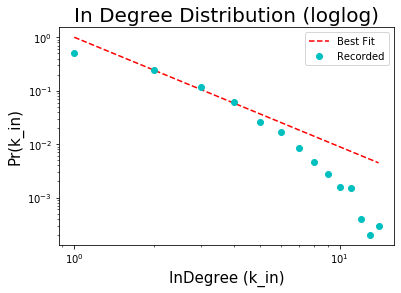

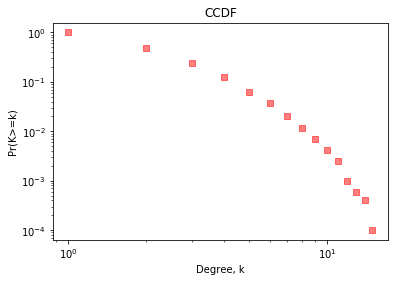

In [14]:
plotDegsStat(inverse_mean_geodesic_model, params, 10)

# Triadic Closure

In [16]:
def triadic_closure_model(size, p = 0.5):
    G = nx.Graph()
    G.add_edge(0,1)
    for i in range(len(G),size):
        first_sel = np.random.randint(0,i)
        if np.random.rand() > p: #flip a coin, if it lands heads, then connect to a random neighbor of the first node -- thus making a triangle
            second_sel = np.random.choice(list(G.neighbors(first_sel)))
        else:
            second_sel = np.random.randint(0,i) #just uniform
        G.add_edges_from([(i, first_sel), (i, second_sel)])
    return G

In [28]:
# Graph parameters
size = 1000
probability = 0.5
params = [size, probability]

==================================================================================================== Done
Triadic Closure Attachment with probability 0.50, uniform attachment with probability 0.50
Correlation:  0.8343404984948773


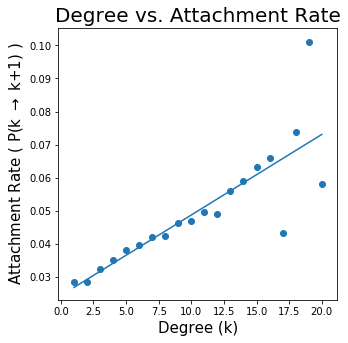

In [35]:
# Test parameters
interval = 500
start = 500
iterations = 10000

k_incr = test_graph(triadic_closure_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Triadic Closure Attachment with probability {:.2f}, uniform attachment with probability {:.2f}".format(1-params[1], params[1]))
print("Correlation: ", r_value)

===================================================================================================== Done
[-1.52341388]


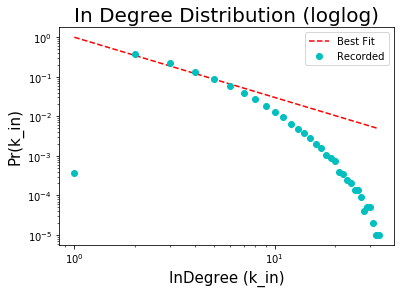

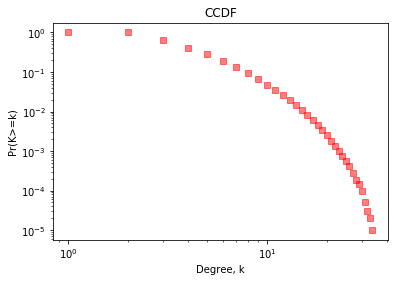

In [19]:
plotDegsStat(triadic_closure_model, params, 100)

In [29]:
# Graph parameters
size = 1000
probability = 0.1
params = [size, probability]

==================================================================================================== Done
Triadic Closure Attachment with probability 0.90, uniform attachment with probability 0.10
Correlation:  0.9100206445758383


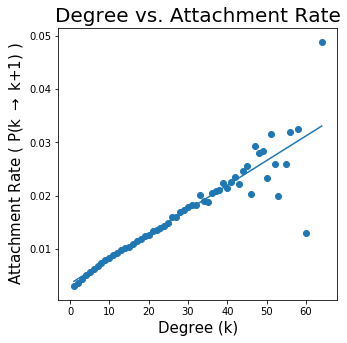

In [20]:
# Test parameters
interval = 500
start = 500
iterations = 10000

k_incr = test_graph(triadic_closure_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Triadic Closure Attachment with probability {:.2f}, uniform attachment with probability {:.2f}".format(1-params[1], params[1]))
print("Correlation: ", r_value)

==================================================================================================== Done
[-1.51320594]


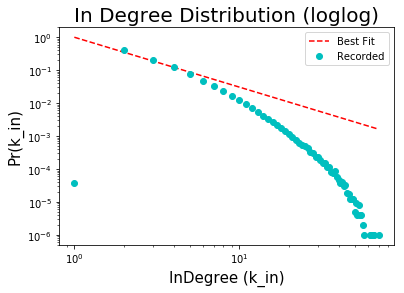

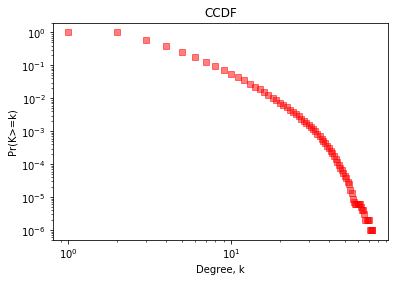

In [12]:
plotDegsStat(triadic_closure_model, params, 1000)

# Local Triangle Count

In [87]:
def local_triangle_count_model(size):
    G = nx.Graph()
    G.add_edge(0,1)
    G.add_edge(1,2)
    G.add_edge(2,0)
    
    triangles = nx.triangles(G).values()
    
    for i in range(len(G), size):
        lcc_sum = sum(triangles)
        prob = [ float(x)/lcc_sum for x in triangles ]
        sel_nodes = np.random.choice(G.nodes(), size=2, p=prob)

        G.add_edge(i, sel_nodes[0])
        G.add_edge(i, sel_nodes[1])
        
        if(sel_nodes[0] in G[sel_nodes[1]]):
            triangles[sel_nodes[0]] += 1
            triangles[sel_nodes[1]] += 1
        triangles.append(nx.triangles(G, i))

    return G

In [30]:
# Graph parameters
size = 1000
params = [size]

('====================================================================================================', 'Done')
('Correlation: ', 0.9960872642008848)


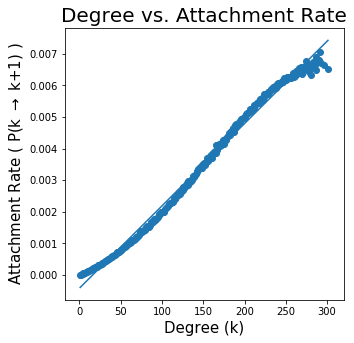

In [92]:
# Test parameters
interval = 500
start = 500
iterations = 10000

k_incr = test_graph(local_triangle_count_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

('==============================================================================================================', 'Done')
[-1.49560855]


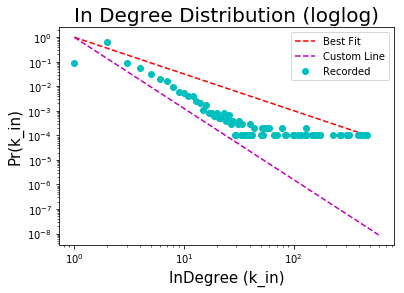

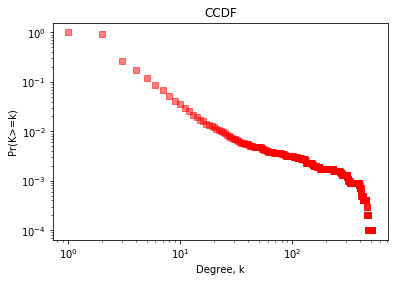

In [102]:
plotDegsStat(local_clustering_coefficient_model, [1000], 10, alpha=-2.9, max_x=600)

# Local Custering Coefficient

In [33]:
def update_probs(G, nodes_to_recalc, prev_lcc_sum = 0, prev_lccs = {}, randomness = 1):
    #returns 1) dictionary that contains the lccs,
    #        2) the previous rounds' lcc sum, so we don't have to recalculate it all
    #        3) the effective probabilities as a list
    num_nodes = nodes_to_recalc[2]+1
    denom = num_nodes+(num_nodes*randomness) #denom needs to be the upper limit of what the numerator for the assigned node probabilities
    cur_lcc_sum = prev_lcc_sum
    cur_lccs = prev_lccs 
    for i in nodes_to_recalc:
        i_neighbors = [] #for efficiency, populate list as we go, only look at neighbor's edges once
        total_num_neighbors = 0 
        num_neighbors_connected = 0
        for node in G.neighbors(i):
            i_neighbors.append(node)
            total_num_neighbors += 1 #also for efficiency
            for node_neighbor in G.neighbors(node):
                if node_neighbor in i_neighbors: 
                    num_neighbors_connected += 1
        if total_num_neighbors <= 1:
            #would cause a division by 0 error
            lcc = 0
        else:
            lcc = (num_neighbors_connected*2)/(total_num_neighbors*(total_num_neighbors-1))
        if i in cur_lccs:
            cur_lcc_sum += (lcc+randomness)-cur_lccs[i]
        else:
            cur_lcc_sum += lcc+randomness
        cur_lccs[i] = lcc+randomness
    effective_probs = []
    for key in cur_lccs.keys():
        effective_probs.append(cur_lccs[key]/denom)
    multiplier = denom/cur_lcc_sum #need the multiplier such that the probabilities add up to 1
    #up to this point, the effective_probs are just ratios, and if we add them all up, they are guaranteed to be less than 1.
    #for that reason, we need to scale it with the multiplier that will guarantee:
    # x((lcc1/denom) + (lcc2/denom) + ... + (lcck/denom)) = 1
    return cur_lccs, cur_lcc_sum, [multiplier*lcc_denom for lcc_denom in effective_probs]

def local_clustering_coefficient_model(size, randomness = 1):  
    #Grows a network based on:
    #    'size' number of nodes
    #    'randomness', a measure of how random the choice is, the higher this number, the more closely we follow uniform attachment, 
    #                  the lower, the more impact of the local clustering coefficient. Must be greater than 0.
    
    #Adds one node at a time, connecting it to 2 pre-existing nodes based on the following criteria
    #LOCAL CLUSTERING COEFFICIENT:
    #    more likely to choose nodes that have a high local clustering coefficient
    
    #Could be made a little bit faster by using something other than np.random.choice().
    
    if randomness <= 0:
        return
    G = nx.Graph()
    G.add_edge(0,1)
    lccs = {0: 0, 1: 0}
    lcc_sum = 0
    selected_nodes = [0, 0, 1]
    for num_nodes in range(2,size):
        lccs, lcc_sum, probs = update_probs(G, selected_nodes, lcc_sum, lccs, randomness) 
        selected_nodes = list(np.random.choice(range(num_nodes), size = 2, p = probs))
        selected_nodes.append(num_nodes)
        G.add_edges_from([(num_nodes, selected_nodes[0]), (num_nodes, selected_nodes[1])])
    return G

In [34]:
# Graph parameters
size = 1000
params = [size]

====================================================================================================== Done
Correlation:  -0.490770775390469


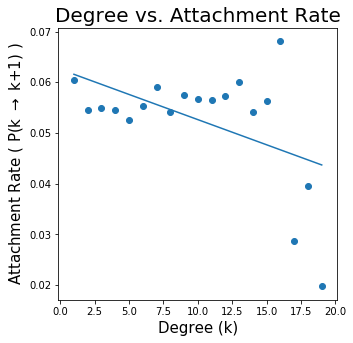

In [36]:
# Test parameters
interval = 500
start = 500
iterations = 50

k_incr = test_graph(local_clustering_coefficient_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

==================================================================================================== Done
[-1.53063347]


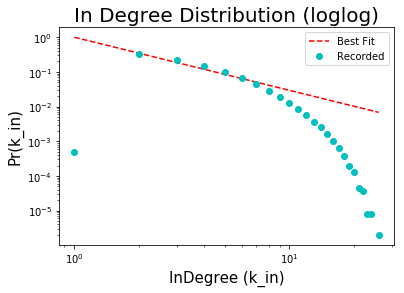

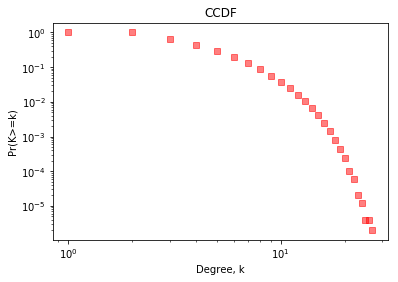

In [143]:
plotDegsStat(local_clustering_coefficient_model, params, 500)